In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import os
import seaborn as sns

# Import your modules
from model import VAE_WGAN
from dataset import get_data_loaders

In [2]:
# ================= CONFIGURATION =================
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "vae_wgan_final.pth"
RESULTS_DIR = "results_advanced"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [3]:
def get_discriminator_features(model, x):
    """
    Extracts high-level features from the Discriminator's convolutional layers.
    """
    # We access the 'net' part of the discriminator defined in model.py
    features = model.discriminator.net(x)
    return features.view(features.size(0), -1)

In [4]:
def plot_histogram(scores, labels, method_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(scores[labels==0], color='green', label='Normal (Forest)', kde=True, stat="density", alpha=0.5)
    sns.histplot(scores[labels==1], color='red', label='Anomaly (Fire)', kde=True, stat="density", alpha=0.5)
    plt.title(f'Score Distribution: {method_name}')
    plt.xlabel('Anomaly Score')
    plt.legend()
    plt.savefig(os.path.join(RESULTS_DIR, 'best_method_histogram.png'))

### ***evaluate_advanced***

In [5]:
print(f"Running Advanced Evaluation on {DEVICE}...")

Running Advanced Evaluation on cuda...


In [6]:
# 1. Load Data & Model
_, test_loader = get_data_loaders('modis_dataset', batch_size=BATCH_SIZE)
model = VAE_WGAN().to(DEVICE)

Total Normal: 4294
Total Fire: 4303
--- Split Summary ---
Train Set (Normal Only): 3435 images
Test Set (Normal):       859 images
Test Set (Fire):         859 images
Total Test Set:          1718 images


In [7]:
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print("Model loaded.")
else:
    print("Model file not found.")

Model loaded.


In [8]:
model.eval()

VAE_WGAN(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2)
      (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2)
    )
    (fc_mu): Linear(in_features=4096, out_features=128, bias=True)
    (fc_logvar): Linear(in_features=4096, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_featu

In [9]:
# Lists to store different types of scores
labels_list = []
mse_scores = []      # Pixel-wise error
critic_scores = []   # Raw Critic output
feature_scores = []  # Feature matching error

In [10]:
print("Computing Scores...")
with torch.no_grad():
    for imgs, labels in tqdm(test_loader):
        imgs = imgs.to(DEVICE)

        # 1. Reconstruct
        recon_imgs, _, _ = model(imgs)

        # --- SCORE A: MSE (Pixel Loss) ---
        # What we used before
        mse_loss = torch.mean((imgs - recon_imgs) ** 2, dim=[1, 2, 3])

        # --- SCORE B: Critic Score ---
        # Does the Discriminator think the input is Real (Normal) or Fake (Anomaly)?
        # Note: WGAN Critic gives higher scores for "Real".
        # So Anomaly Score should be -Critic_Score (Low Realness = High Anomaly)
        crit_out = model.discriminator(imgs).squeeze()

        # --- SCORE C: Feature Matching Loss ---
        # Compare internal features of Input vs Reconstruction
        # This captures TEXTURE differences, ignoring simple color matches
        feat_real = get_discriminator_features(model, imgs)
        feat_recon = get_discriminator_features(model, recon_imgs)
        feat_loss = torch.mean((feat_real - feat_recon) ** 2, dim=1)

        # Append to lists
        mse_scores.extend(mse_loss.cpu().numpy())
        critic_scores.extend(-crit_out.cpu().numpy()) # Invert so High = Anomaly
        feature_scores.extend(feat_loss.cpu().numpy())
        labels_list.extend(labels.numpy())

Computing Scores...


100%|██████████| 54/54 [00:13<00:00,  3.99it/s]


In [11]:
# Convert to arrays
labels = np.array(labels_list)
scores_dict = {
    "MSE (Pixels)": np.array(mse_scores),
    "Critic (Realism)": np.array(critic_scores),
    "Feature (Texture)": np.array(feature_scores)
}


--- MSE (Pixels) ---
AUC: 0.4134
Mean Normal Score: 0.0496
Mean Fire Score:   0.0161

--- Critic (Realism) ---
AUC: 0.5876
Mean Normal Score: 11.5065
Mean Fire Score:   13.7463

--- Feature (Texture) ---
AUC: 0.4000
Mean Normal Score: 0.0758
Mean Fire Score:   0.0381

Saved comparison plot to results_advanced\advanced_roc_comparison.png

🏆 Best Method: Critic (Realism) with AUC 0.5876


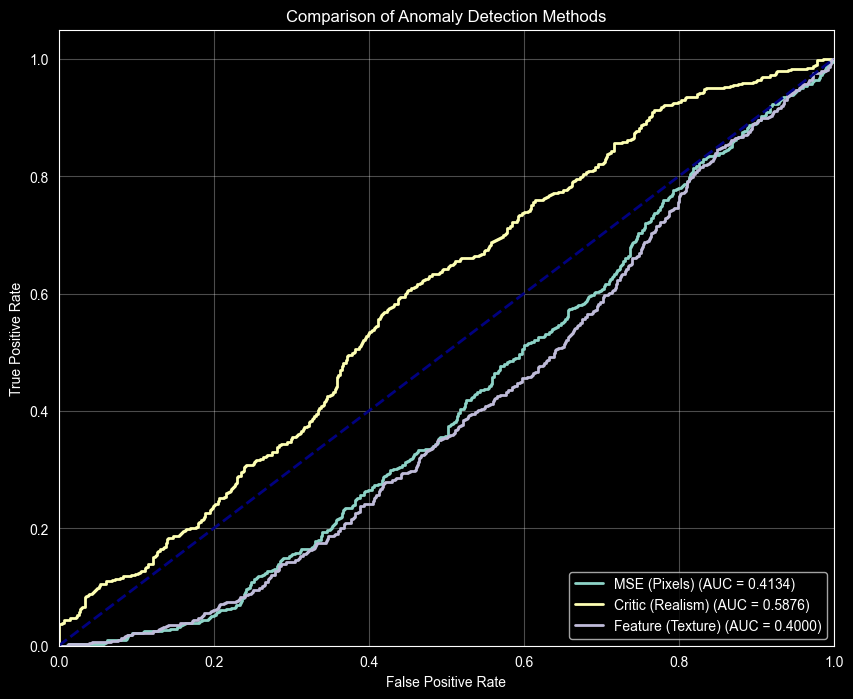

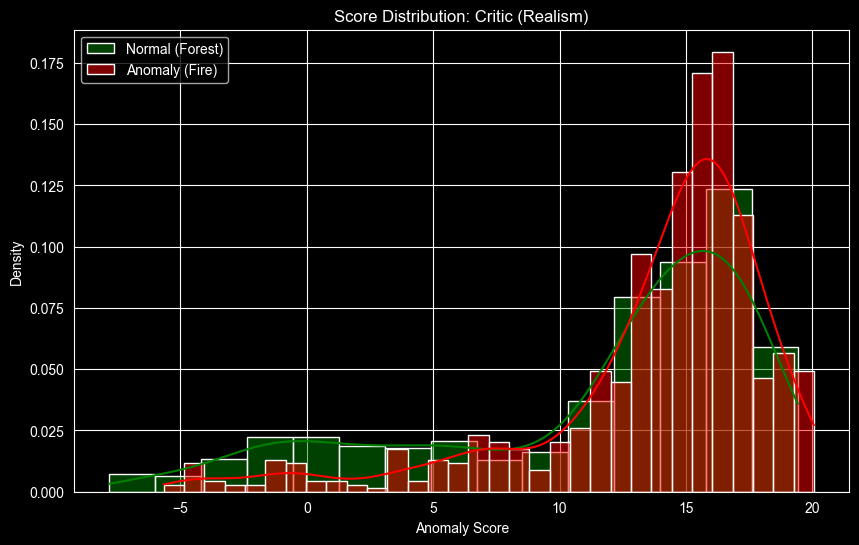

In [12]:
# 2. Plot ROC Curves for all methods
plt.figure(figsize=(10, 8))

best_auc = 0
best_method = ""

for name, scores in scores_dict.items():
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    # Track winner
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_method = name

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

    # Optional: Print distribution stats
    print(f"\n--- {name} ---")
    print(f"AUC: {roc_auc:.4f}")
    print(f"Mean Normal Score: {np.mean(scores[labels==0]):.4f}")
    print(f"Mean Fire Score:   {np.mean(scores[labels==1]):.4f}")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of Anomaly Detection Methods')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

save_path = os.path.join(RESULTS_DIR, 'advanced_roc_comparison.png')
plt.savefig(save_path)
print(f"\nSaved comparison plot to {save_path}")
print(f"\n🏆 Best Method: {best_method} with AUC {best_auc:.4f}")

# 3. Plot Histograms for the Winner
plot_histogram(scores_dict[best_method], labels, best_method)